### Importando Bibliotecas para Obtenção e Tratamento dos Dados

In [5]:
from dotenv import load_dotenv
import os
import time
import pandas as pd
import requests as rq
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

load_dotenv()

True

#### Spotify API credentials

A primeira etapa para a obtenção dos dados é a autenticação na API do Spotify. Para isso, é necessário criar um app no [Spotify for Developers](https://developer.spotify.com/dashboard/login) e obter as credenciais de acesso.

In [6]:
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

In [7]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)     
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Criação de dataframe

Para criação do nosso dataframe, vamos utilizar a biblioteca [pandas](https://pandas.pydata.org/). Iremos selecionar as colunas que serão utilizadas para a análise e renomeá-las para facilitar a manipulação dos dados. Em seguiga, criaremos funções para extrair, através da função `.search()`, estes dados de cada música e adicioná-los ao dataframe.


- Referência 1: https://developer.spotify.com/documentation/web-api/reference/get-audio-features
- Referência 2: https://www.youtube.com/watch?v=RHIJpN5a_bk

In [8]:
def create_dataframe(query_list, limit=50):
    # Criar um dicionário para armazenar os dados
    data = {
        'Track ID': [],
        'Track Name': [],
        'Artist Name': [],
        'Popularity Score': [],
        'Release Year': [],
        'Genre': []
    }
    for query in query_list:
        # Fazer a busca no Spotify
        search_results = sp.search(query, limit=limit, type='track')
        tracks = search_results['tracks']['items']
        # Extrair as informações necessárias
        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track Name'].append(track['name'])
            data['Artist Name'].append(track['artists'][0]['name'])
            data['Popularity Score'].append(track['popularity'])
            data['Release Year'].append(track['album']['release_date'][:4])
            data['Genre'].append(query.replace('genre:', '').replace('"', ''))
        
        # Esperar por 2 segundos para evitar sobrecarga
        time.sleep(2)

    # Converter a dataframe
    df = pd.DataFrame(data)

    return df

def get_audio_features(track_ids):
    features_list = []

    for i in range(0, len(track_ids), 50):
        # Fazer a busca no Spotify
        batch = track_ids[i:i+50]
        # .audio_features() retorna uma lista de dicionários
        features_results = sp.audio_features(batch)
        features_list += features_results

    return features_list

### Seleção de Variáveis

Até este ponto, selecionamos as seguintes variáveis para análise:

- `Track ID`: identificador único da música.
- `Track Name`: nome da música.
- `Artist Name`: nome do artista.
- `Release Year`: ano de lançamento da música.
- `Popularity`: popularidade da música.
- `Danceability`: quão é adequada para dançar com base em uma combinação de elementos musicais, incluindo tempo, estabilidade rítmica, força de batida e regularidade geral.
- `Energy`: mede a intensidade e atividade. Geralmente, as músicas energéticas são rápidas e barulhentas.
- `Key`: mede a tonalidade da música.
- `Loudness`: volume geral da música em decibéis.
- `Mode`: modo
- `Speechiness`: detecta a presença de palavras faladas em uma música.
- `Acousticness`: acústica
- `Instrumentalness`: mede a instrumentalidade, prediz se uma música não contém vocais.
- `Liveness`: mede a vivacidade, detecta a presença de uma audiência na gravação.
- `Valence`: valência da música, mede a positividade.
- `Tempo`: tempo estimado da música em batidas por minuto (BPM).
- `Duration (ms)`: duração da música em milissegundos
- `Time Signature`: assinatura de tempo

#### Selecionando gêneros musicais

In [9]:
# Selecionando os gêneros
genres = ['genre:"Global Top 50"', 'genre:"Top Lists"', 'genre:"Pop"', 'genre:"Hip-Hop"', 'genre:"Dance / Electronic"', 'genre:"Rock"', 'genre:"Romance"', 'genre:"Indie"', 'genre:"R&B"', 'genre:"Country"', 'genre:"Folk & Acoustic"', 'genre:"Metal"', 'genre:"Latin"', 'genre:"Jazz"', 'genre:"Blues"', 'genre:"Reggae"', 'genre:"Classical"', 'genre:"Soul"', 'genre:"Funk"', 'genre:"Punk"', 'genre:"Lo-fi"', 'genre:"Anime"']
# Criando o dataframe
df = create_dataframe(genres, limit=50)

In [10]:
#count values 
df['Genre'].value_counts()

Pop          50
Hip-Hop      50
Lo-fi        50
Punk         50
Funk         50
Soul         50
Classical    50
Reggae       50
Blues        50
Jazz         50
Latin        50
Metal        50
Country      50
R&B          50
Indie        50
Romance      50
Rock         50
Anime        50
Name: Genre, dtype: int64

Com isso, coletamos 900 músicas para nossas análises, para mais informações iremos obter informações de áudio sobre cada uma delas.

#### Adicionando colunas de informações de áudio

In [11]:
# Obtendo os ids das músicas
track_ids = df['Track ID'].tolist()
# Obtendo as features de áudio
audio_features = get_audio_features(track_ids)
# Convertendo para dataframe
audio_features_df = pd.DataFrame(audio_features)
# Juntando os dataframes
df = df.merge(audio_features_df, left_on='Track ID', right_on="id", how='inner')
# Tornando a primeira letra de cada coluna maiúscula
df.columns = df.columns.str.capitalize()

### Estatística Descritiva

Através do df.describe(), podemos analisar a estatística descritiva das variáveis numéricas, como média, desvio padrão, valor mínimo e máximo, quartis, etc.

In [12]:
df.describe()

,Popularity score,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time_signature
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.00000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,77.690189,0.601951,0.595095,4.993115,-8.393043,0.60327,0.077453,0.321226,0.086883,0.164845,0.493783,117.001604,210336.086919,3.889845
std,13.283319,0.173171,0.240876,3.497747,5.814627,0.48943,0.075538,0.327144,0.240527,0.122198,0.237815,30.301630,56485.408433,0.427218
min,17.000000,0.000000,0.002680,0.000000,-39.245000,0.00000,0.000000,0.000008,0.000000,0.027100,0.000000,0.000000,61176.000000,0.000000
25%,75.000000,0.492000,0.423250,2.000000,-9.918000,0.00000,0.035300,0.037350,0.000000,0.093300,0.298000,94.059500,173033.250000,4.000000
50%,81.000000,0.603000,0.644000,5.000000,-7.075000,1.00000,0.049050,0.178500,0.000019,0.117000,0.497500,113.174000,206333.500000,4.000000
75%,85.000000,0.739000,0.774000,8.000000,-4.931000,1.00000,0.080400,0.577000,0.003290,0.195000,0.663750,136.382500,237583.500000,4.000000
max,100.000000,0.971000,0.990000,11.000000,-0.517000,1.00000,0.568000,0.996000,0.970000,0.941000,0.981000,206.247000,592920.000000,5.000000


### Correlação entre variáveis

Através do df.corr(), podemos analisar a correlação entre as variáveis numéricas, ou seja, o quanto uma variável influencia na outra.

In [13]:
numeric_columns = ['Popularity score', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
correlation = df[numeric_columns].corr()
correlation 

,Popularity score,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
Popularity score,1.000000,0.355360,0.347850,0.384057,0.116510,-0.451222,-0.224261,0.017581,0.091132,0.074805
Danceability,0.355360,1.000000,0.295136,0.421448,0.282586,-0.334566,-0.398875,-0.043722,0.449519,0.011969
Energy,0.347850,0.295136,1.000000,0.789940,0.122165,-0.770608,-0.439631,0.141685,0.483093,0.268440
Loudness,0.384057,0.421448,0.789940,1.000000,0.107741,-0.664139,-0.673162,0.140368,0.367056,0.191405
Speechiness,0.116510,0.282586,0.122165,0.107741,1.000000,-0.081604,-0.119337,-0.005997,0.031384,0.193586
Acousticness,-0.451222,-0.334566,-0.770608,-0.664139,-0.081604,1.000000,0.419715,-0.102699,-0.315706,-0.161952
Instrumentalness,-0.224261,-0.398875,-0.439631,-0.673162,-0.119337,0.419715,1.000000,-0.094650,-0.353935,-0.173206
Liveness,0.017581,-0.043722,0.141685,0.140368,-0.005997,-0.102699,-0.094650,1.000000,0.077543,0.006532
Valence,0.091132,0.449519,0.483093,0.367056,0.031384,-0.315706,-0.353935,0.077543,1.000000,0.135643
Tempo,0.074805,0.011969,0.268440,0.191405,0.193586,-0.161952,-0.173206,0.006532,0.135643,1.000000


### Agrupando os Gêneros por Popularidade

In [14]:
genre_popularity = df.groupby('Genre')['Popularity score'].mean().sort_values(ascending=False)
genre_popularity

Genre
Pop          88.746479
Hip-Hop      86.118644
Latin        85.870588
Reggae       85.313953
R&B          84.877193
Rock         83.873239
Indie        82.957143
Country      82.750000
Metal        80.220588
Soul         79.711864
Punk         78.439394
Funk         78.338235
Blues        74.292308
Lo-fi        72.690909
Jazz         71.967213
Anime        69.264151
Classical    65.407407
Romance      25.600000
Name: Popularity score, dtype: float64

### Agrupando os Gêneros por Dançabilidade

In [15]:
genre_danceability = df.groupby('Genre')['Danceability'].mean().sort_values(ascending=False)
genre_danceability

Genre
Reggae       0.803663
Latin        0.801494
Hip-Hop      0.694000
R&B          0.664175
Funk         0.660794
Soul         0.644186
Lo-fi        0.601236
Pop          0.593817
Rock         0.589366
Blues        0.577246
Jazz         0.564492
Anime        0.563487
Indie        0.560800
Country      0.538484
Punk         0.533318
Metal        0.502000
Romance      0.443940
Classical    0.302513
Name: Danceability, dtype: float64

### Agrupando todas as colunas numéricas por gênero

Basicamente, podemos criar um dataframe com todos as colunas numéricas agrupadas por gênero. Isso nos permitirá visualizar as diferenças entre os gêneros de uma forma mais clara.

In [16]:
genre_df = df.groupby('Genre').mean(numeric_only=True)
genre_df.to_csv('genre_df.csv')
genre_df

,Popularity score,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time_signature
Genre,,,,,,,,,,,,,,
Anime,69.264151,0.563487,0.737215,5.037736,-6.892830,0.452830,0.083779,0.214111,0.221252,0.183006,0.467242,116.661075,199748.490566,3.943396
Blues,74.292308,0.577246,0.609738,4.430769,-7.502154,0.707692,0.053346,0.279529,0.030968,0.183688,0.534246,116.981554,218437.092308,3.892308
Classical,65.407407,0.302513,0.084115,4.851852,-26.691981,0.648148,0.045606,0.954315,0.838568,0.113443,0.152763,97.308259,212543.888889,3.351852
Country,82.750000,0.538484,0.539203,5.171875,-7.168156,0.875000,0.038163,0.479386,0.000455,0.147825,0.422783,119.506891,207966.359375,3.937500
Funk,78.338235,0.660794,0.728735,6.279412,-6.923441,0.602941,0.093672,0.118042,0.013711,0.159522,0.653840,106.142794,244806.044118,4.000000
Hip-Hop,86.118644,0.694000,0.572322,5.101695,-7.121102,0.440678,0.136483,0.186557,0.011630,0.187419,0.392607,124.285932,223074.542373,3.847458
Indie,82.957143,0.560800,0.569943,5.400000,-8.160400,0.757143,0.044076,0.341825,0.137543,0.154177,0.433903,113.188200,204911.942857,3.928571
Jazz,71.967213,0.564492,0.448625,5.918033,-10.406787,0.606557,0.065362,0.576392,0.027701,0.158267,0.573639,116.494426,210514.459016,3.721311
Latin,85.870588,0.801494,0.708671,4.752941,-5.107635,0.376471,0.112648,0.223607,0.000695,0.156326,0.559012,119.948588,203130.611765,3.929412


## Criação de Gráficos

#### Importando bibliotecas para gerar visualizações

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

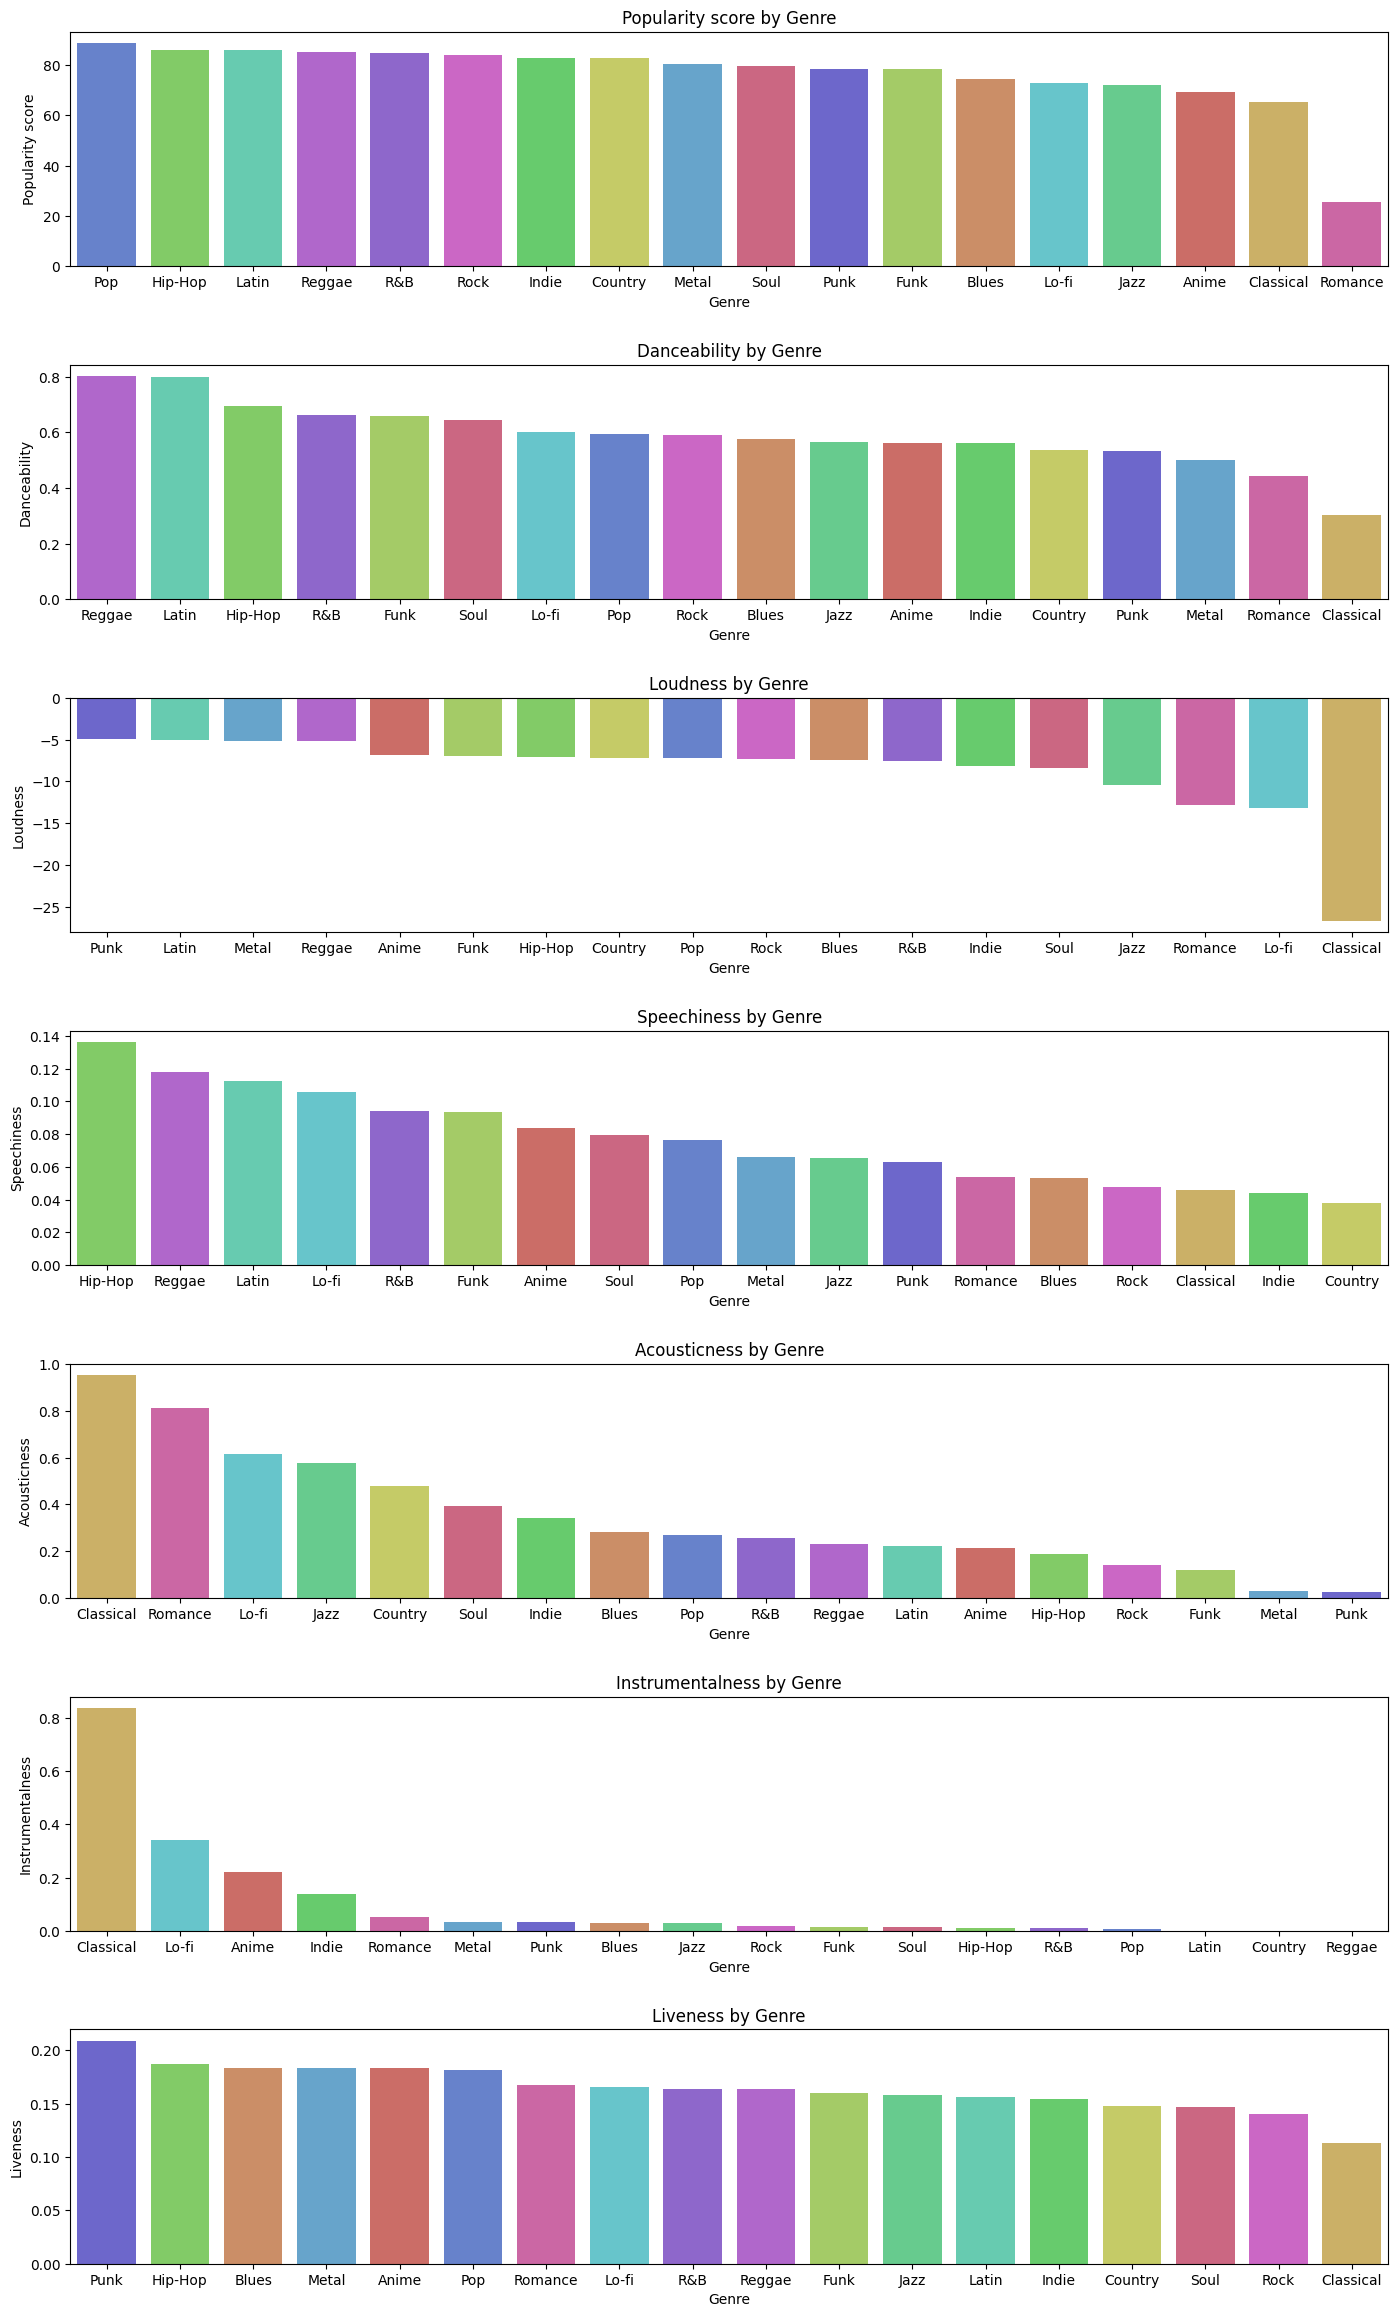

In [18]:
# Lista de colunas para plotar
columns = ['Popularity score', 'Danceability', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']

# Gerando uma paleta de cores consistente para cada gênero
unique_genres = genre_df.index.unique()
palette = dict(zip(unique_genres, sns.color_palette("hls", len(unique_genres))))

fig, ax = plt.subplots(figsize=(15, 24), ncols=1, nrows=columns.__len__())
# Ajustando o espaçamento entre os gráficos
fig.tight_layout(pad=5.0)
# Loop para plotar os gráficos
for i, col in enumerate(columns):
    order = genre_df.sort_values(by=col, ascending=False).index
    sns.barplot(x=genre_df.index, y=col, data=genre_df, ax=ax[i], order=order, palette=palette)
    ax[i].set_title(col + " by Genre")

### Correlograma entre as variáveis numéricas

Como visto anteriormente, havíamos analisado a correlação entre as variáveis numéricas. Agora, podemos visualizar isso através de um correlograma. Podemos ver que há forte correlação entre as variáveis "Energy" e "Loudness". E correlação positiva com "Danceability" e "Popularity".

Por outro lado há correlação negativa destas com "Acousticness" e "Instrumentalness".  O que indica que músicas mais dançantes e populares tendem a ser mais energéticas e barulhentas.

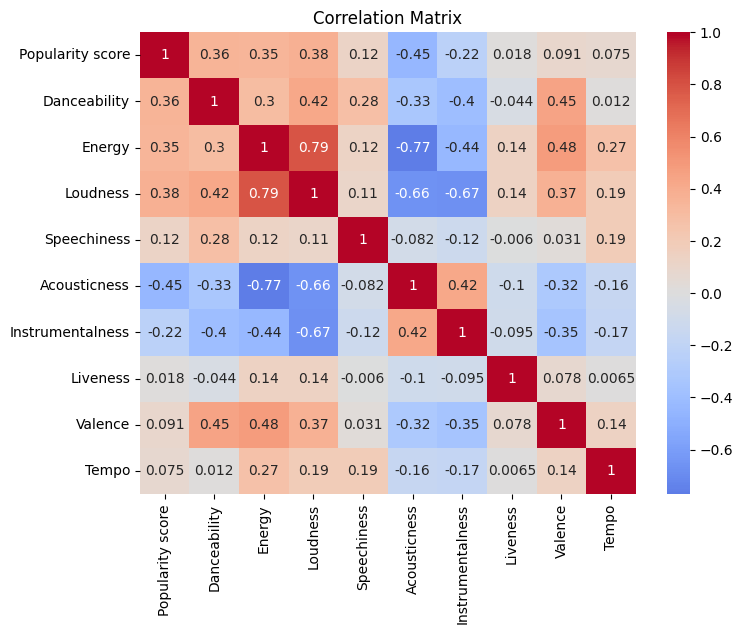

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Distribuição de minutos de duração das músicas 

Aqui temos uma visão geral que indica que a maioria das músicas tem entre 3 e 4 minutos de duração. Onde músicas "Funk" são as mais longas com uma média de 4.08 minutos, e as músicas "Lo-fi" são as mais curtas com uma média de 2.79 minutos.

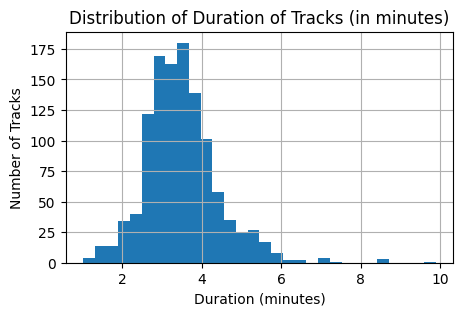

In [20]:
# Converter a coluna de duração para minutos
df['Duration_minutes'] = df['Duration_ms'] / (1000 * 60)
# Plotar o histograma
df['Duration_minutes'].hist(bins=30, figsize=(5, 3))
plt.title('Distribution of Duration of Tracks (in minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Tracks')
plt.show()

In [21]:
#Duração média das músicas por gênero
genre_duration = df.groupby('Genre')['Duration_minutes'].mean().sort_values(ascending=False)
genre_duration

Genre
Funk         4.080101
Metal        3.965786
Rock         3.807229
Soul         3.753229
Hip-Hop      3.717909
Blues        3.640618
Classical    3.542398
Jazz         3.508574
Country      3.466106
Indie        3.415199
Latin        3.385510
R&B          3.348980
Reggae       3.341033
Anime        3.329142
Pop          3.314325
Punk         3.296438
Romance      3.266454
Lo-fi        2.796226
Name: Duration_minutes, dtype: float64

### Popularidade por Ano de Lançamento

Aqui coletamos a popularidade média *atual* de nossas músicas baseadas em seu ano de lançamento. Podemos ver que músicas pop dos últimos anos são semelhantes em popularidade. Além disso, músicas "Hip Hop", "Rock" e "R&B" mais recentes também estão em alta.

In [24]:
# Agrupando os dados por ano e gênero
year_genre_popularity = df.groupby(['Release year', 'Genre'])['Popularity score'].mean().reset_index()
# Garantindo que o ano seja um inteiro para que o gráfico seja ordenado corretamente
year_genre_popularity['Release year'] = year_genre_popularity['Release year'].astype(int)
year_genre_popularity = year_genre_popularity.sort_values(by='Release year')
year_genre_popularity = year_genre_popularity[(year_genre_popularity['Release year'] >= 2013)]
# Determinando os top 7 gêneros
top_genres = year_genre_popularity.groupby('Genre')['Popularity score'].mean().nlargest(7).index
# Filter the year_genre_popularity to only include top 10 genres
filtered_data = year_genre_popularity[year_genre_popularity['Genre'].isin(top_genres)]

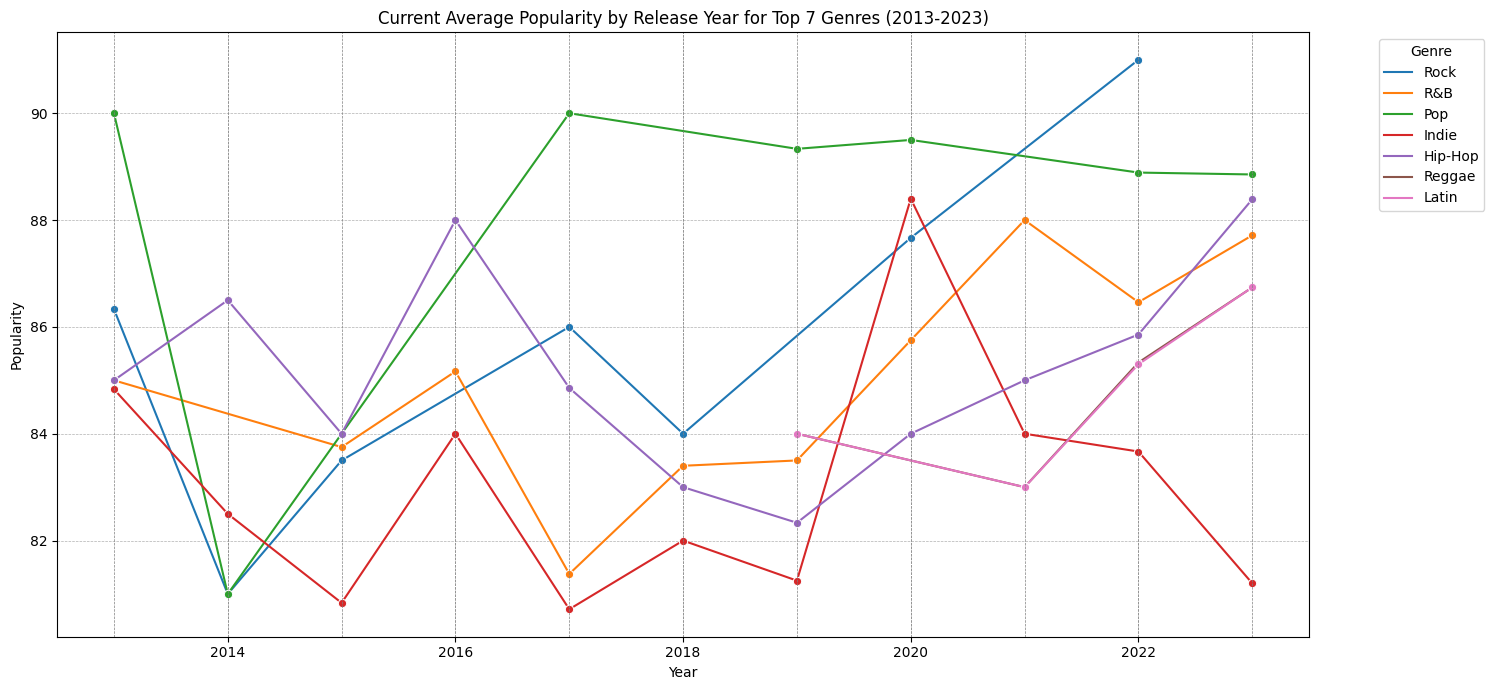

In [25]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=filtered_data, x='Release year', y='Popularity score', hue='Genre', marker="o", dashes=False)

# Add vertical lines
for year in sorted(filtered_data['Release year'].unique()):
    plt.axvline(x=year, color='grey', linestyle='--', linewidth=0.5)

plt.title('Current Average Popularity by Release Year for Top 7 Genres (2013-2023)')
plt.ylabel('Popularity')
plt.xlabel('Year')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
